# Model Report

In [1]:
import logging
from time import time
from typing import Optional

import arviz as az
import matplotlib.pyplot as plt

from speclet import model_configuration
from speclet.analysis.arviz_analysis import describe_mcmc
from speclet.bayesian_models import get_bayesian_model
from speclet.io import project_root
from speclet.loggers import set_console_handler_level
from speclet.managers.cache_manager import (
    get_cached_posterior,
    get_posterior_cache_name,
)
from speclet.project_configuration import get_bayesian_modeling_constants
from speclet.project_enums import ModelFitMethod

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
notebook_tic = time()
set_console_handler_level(logging.WARNING)
%config InlineBackend.figure_format = "retina"
HDI_PROB = get_bayesian_modeling_constants().hdi_prob

Parameters for papermill:

- `MODEL_NAME`: name of the model
- `FIT_METHOD`: method used to fit the model; either "ADVI" or "MCMC"
- `CONFIG_PATH`: path to configuration file
- `ROOT_CACHE_DIR`: path to the root caching directory

## Setup

### Papermill parameters

In [3]:
CONFIG_PATH = ""
MODEL_NAME = ""
FIT_METHOD_STR = ""
ROOT_CACHE_DIR = ""

In [4]:
# Parameters
MODEL_NAME = "hierarchical-nb"
FIT_METHOD_STR = "PYMC3_MCMC"
CONFIG_PATH = "models/model-configs.yaml"
ROOT_CACHE_DIR = "models"

In [5]:
FIT_METHOD = ModelFitMethod(FIT_METHOD_STR)
model_config = model_configuration.get_configuration_for_model(
    config_path=project_root() / CONFIG_PATH, name=MODEL_NAME
)
model = get_bayesian_model(model_config.model)()
trace = get_cached_posterior(
    get_posterior_cache_name(MODEL_NAME, FIT_METHOD),
    cache_dir=project_root() / ROOT_CACHE_DIR,
)

## Fit diagnostics

R-HAT
<xarray.Dataset>
Dimensions:      (sgrna: 16954, cell_line: 87, gene: 2000, lineage: 2, eta_dim_0: 874194, mu_dim_0: 874194)
Coordinates:
  * sgrna        (sgrna) object 'AAAAAAAAATCCAGAACCT' ... 'TTTTGTTAAGTGACCACCT'
  * cell_line    (cell_line) object 'ACH-000007' 'ACH-000009' ... 'ACH-002233'
  * gene         (gene) object 'A1BG' 'AAK1' 'AAR2' ... 'ZSWIM2' 'ZSWIM4'
  * lineage      (lineage) object 'bone' 'colorectal'
  * eta_dim_0    (eta_dim_0) int64 0 1 2 3 4 ... 874190 874191 874192 874193
  * mu_dim_0     (mu_dim_0) int64 0 1 2 3 4 ... 874190 874191 874192 874193
Data variables: (12/14)
    z            float64 1.021
    a            (sgrna) float64 1.003 0.9998 1.002 1.0 ... 1.002 1.002 0.9998
    delta_b      (cell_line) float64 1.016 1.016 1.009 ... 1.008 1.016 1.014
    delta_d      (gene, lineage) float64 1.001 1.001 1.005 ... 1.001 1.002 1.003
    sigma_a      float64 1.003
    sigma_b      float64 1.01
    ...           ...
    d            (gene, lineage) float64 

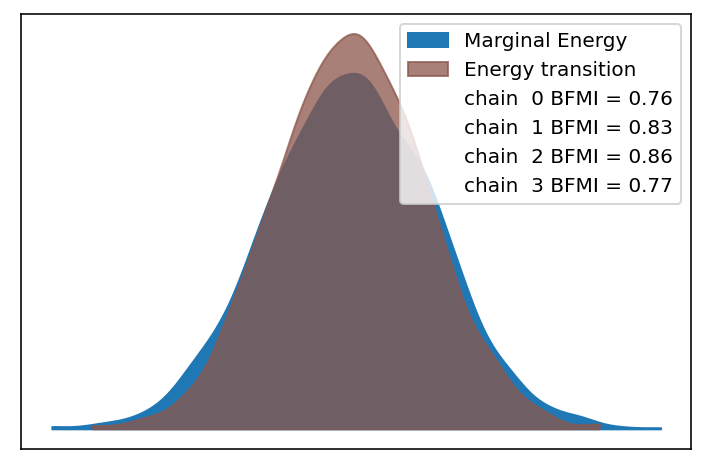

In [6]:
if "MCMC" in FIT_METHOD.value:
    print("R-HAT")
    print(az.rhat(trace))
    print("=" * 60)
    describe_mcmc(trace)

## Model parameters

In [7]:
var_regex = model.vars_regex(FIT_METHOD)
var_regex += ["~^log_lik$", "~^y_hat$"]

/n/data1/hms/dbmi/park/Cook/speclet/.snakemake/conda/6337336a7c816194e7bf8de34b0d1ef5/lib/python3.9/site-packages/arviz/utils.py:129: UserWarning: Items starting with ~: ['^log_lik$', '^y_hat$'] have not been found and will be ignored
  warnings.warn(


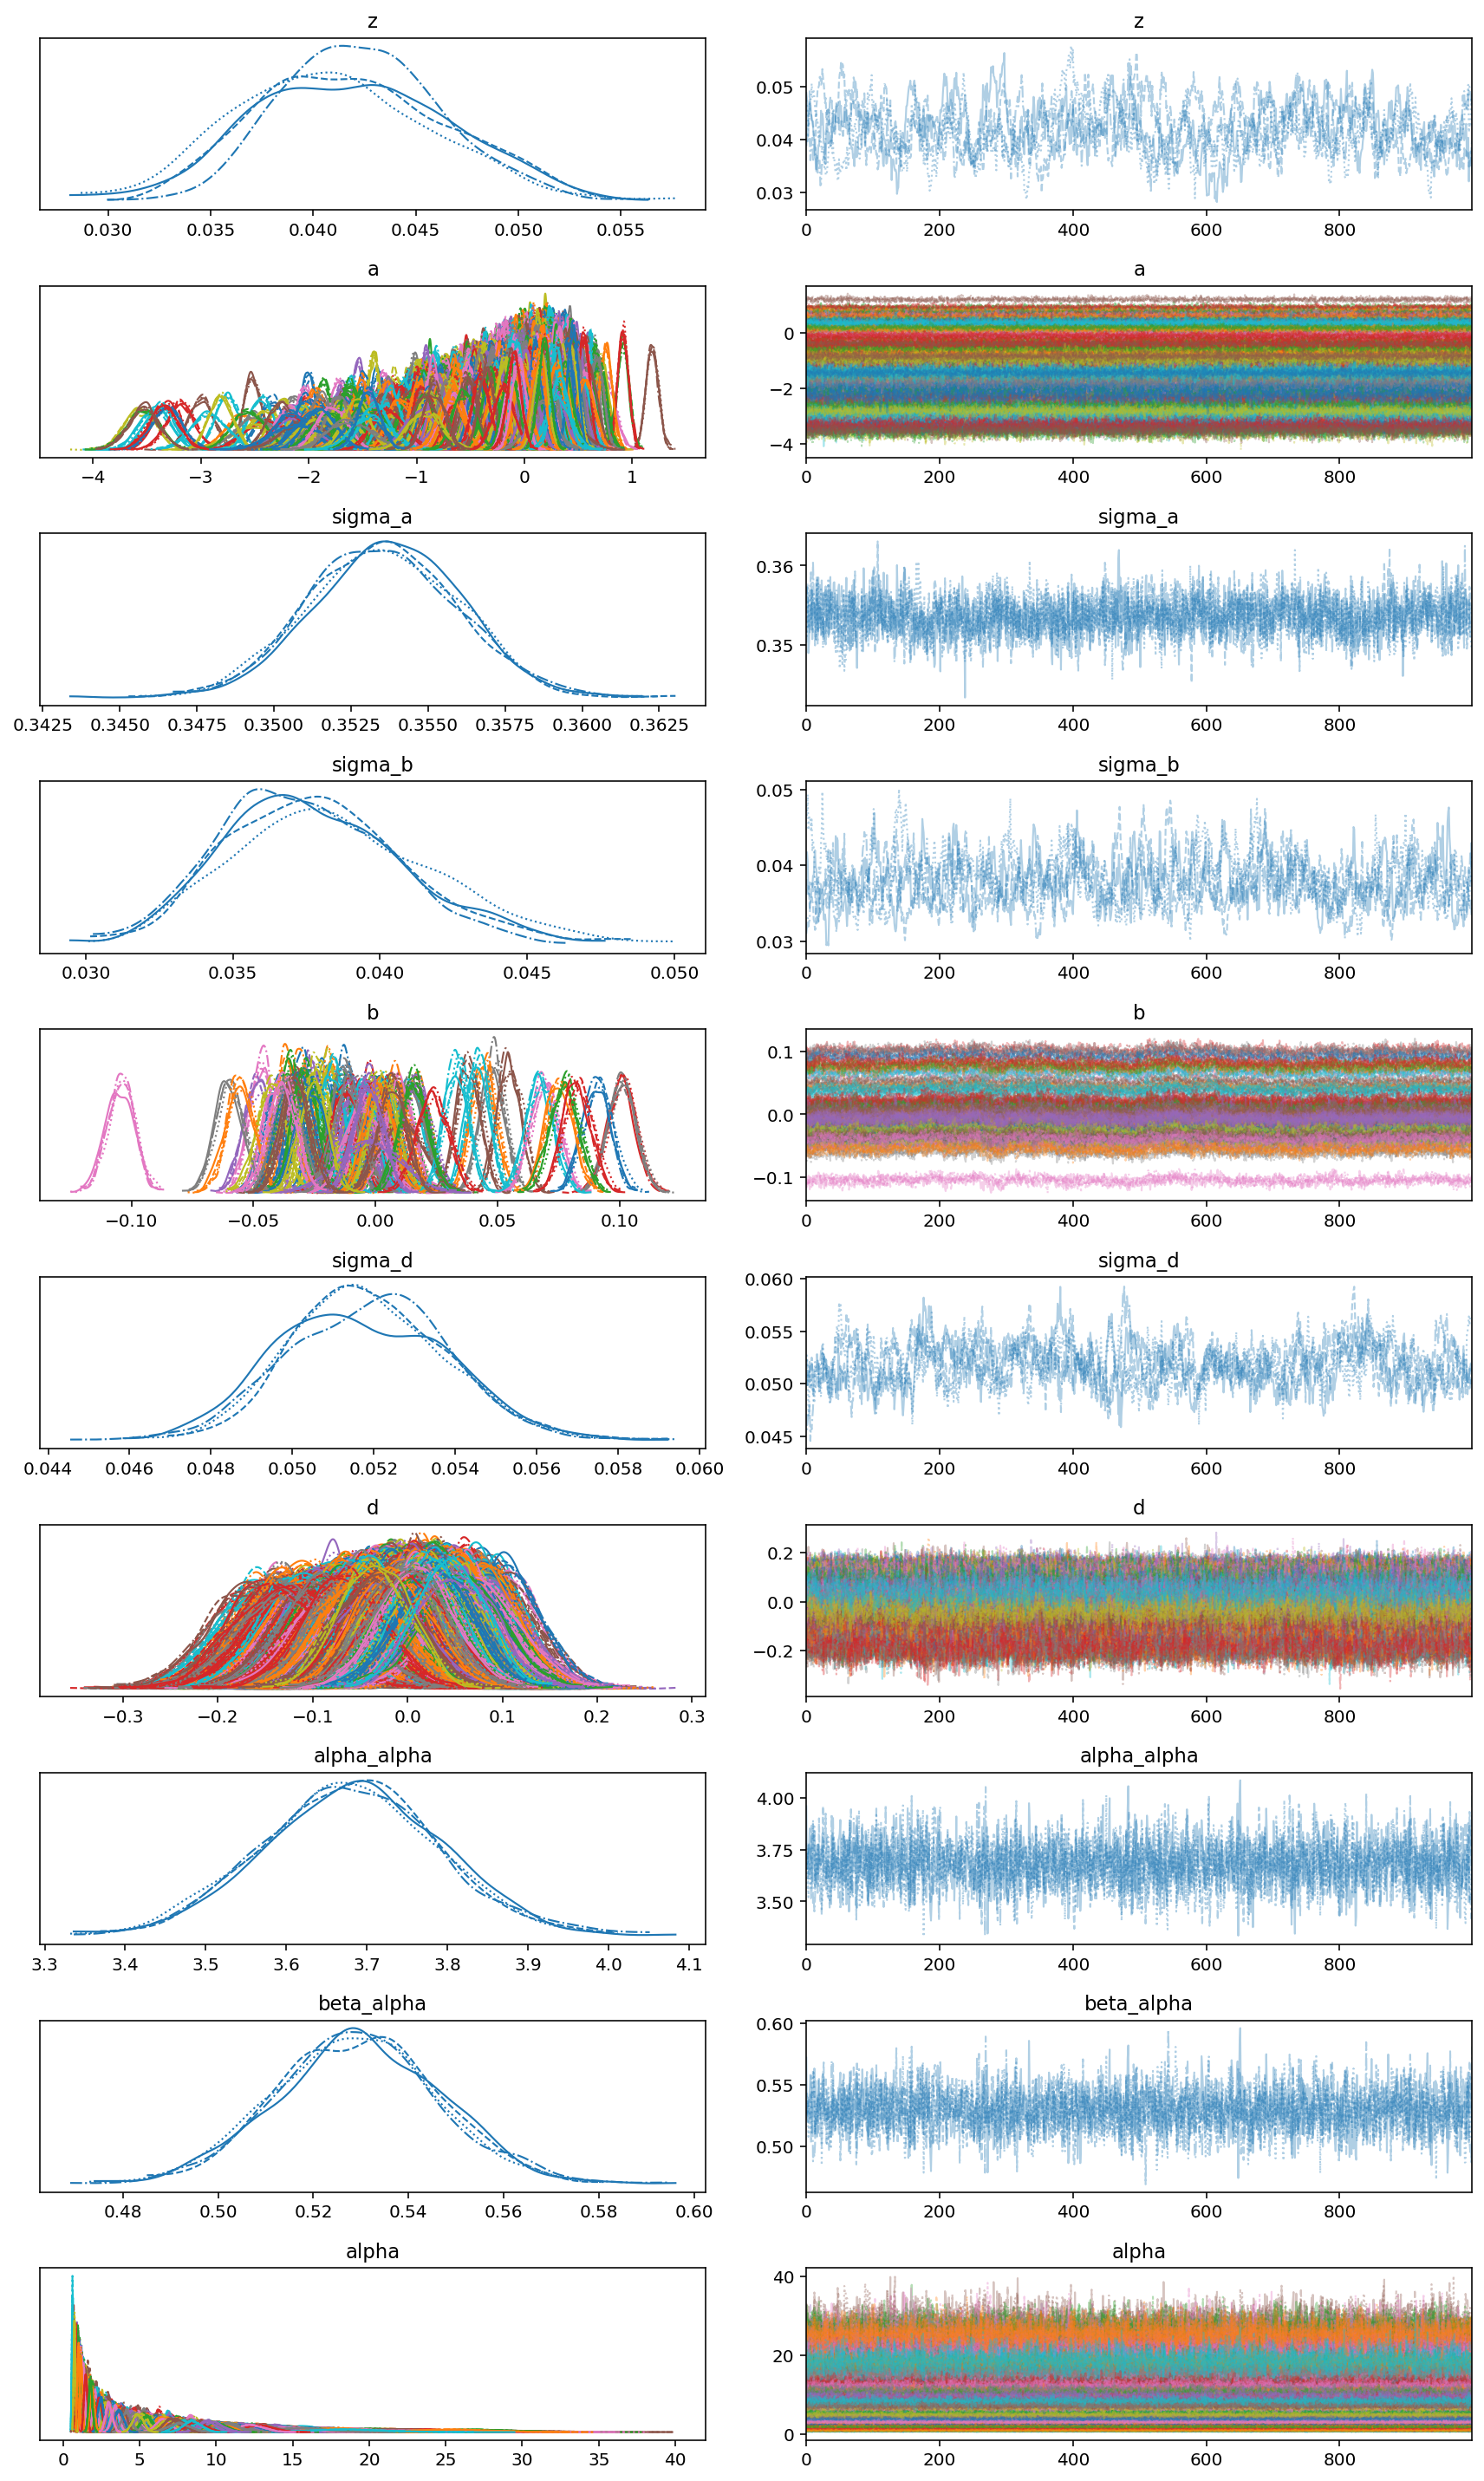

In [8]:
az.plot_trace(trace, var_names=var_regex, filter_vars="regex")
plt.tight_layout()
plt.show()

## Model predictions

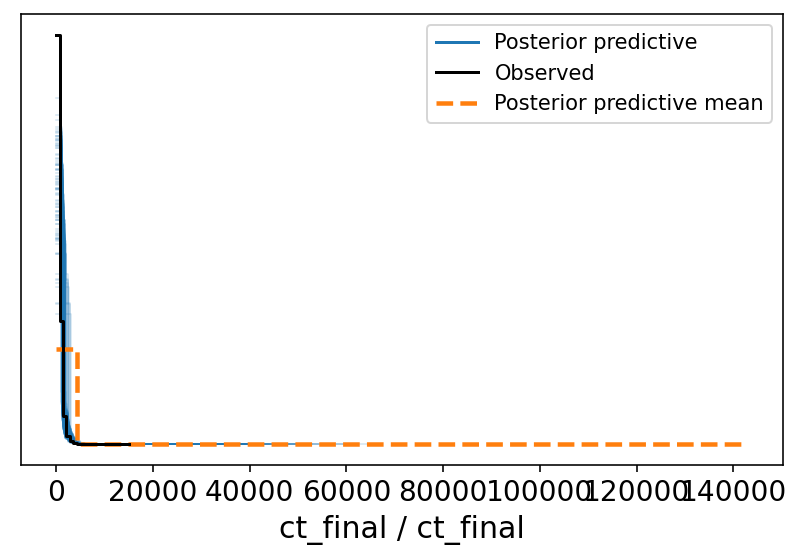

In [9]:
data_pairs: Optional[dict[str, str]] = None

# NOTE: This is a bit of a hack for now...
if FIT_METHOD is ModelFitMethod.STAN_MCMC:
    # obs_var = model.stan_idata_addons["observed_data"][0]
    # ppc_var = model.stan_idata_addons["posterior_predictive"][0]
    obs_var = list(trace.observed_data.data_vars.keys())[0]
    ppc_var = list(trace.posterior_predictive.data_vars.keys())[0]
    data_pairs = {obs_var: ppc_var}


az.plot_ppc(trace, data_pairs=data_pairs, num_pp_samples=100, random_seed=123)
plt.tight_layout()
plt.show()

In [10]:
psis_loo = az.loo(trace, pointwise=True)
psis_loo

/n/data1/hms/dbmi/park/Cook/speclet/.snakemake/conda/6337336a7c816194e7bf8de34b0d1ef5/lib/python3.9/site-packages/arviz/stats/stats.py:694: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


Computed from 4000 by 874194 log-likelihood matrix

         Estimate       SE
elpd_loo -5760684.30  1199.65
p_loo    23828.65        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                          Count   Pct.
(-Inf, 0.5]   (good)     873586   99.9%
 (0.5, 0.7]   (ok)          431    0.0%
   (0.7, 1]   (bad)         131    0.0%
   (1, Inf)   (very bad)     46    0.0%

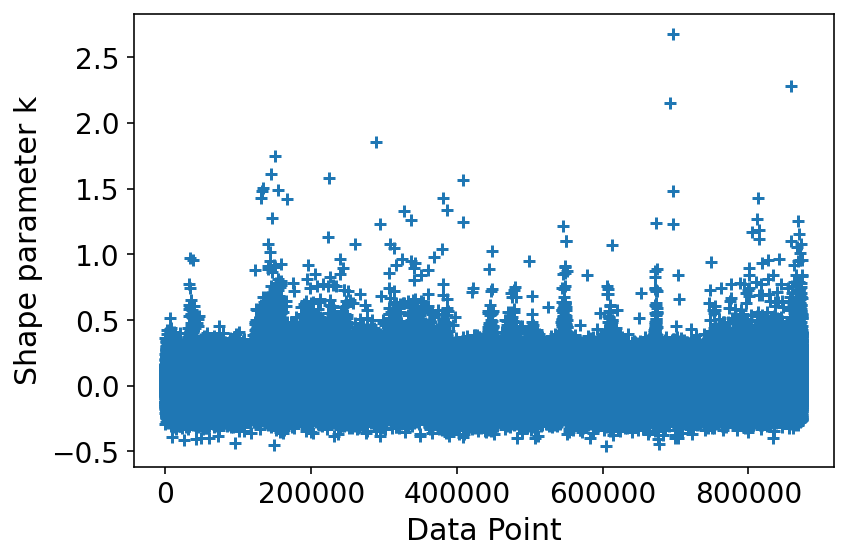

In [11]:
az.plot_khat(psis_loo)
plt.tight_layout()
plt.show()

---

In [12]:
notebook_toc = time()
print(f"execution time: {(notebook_toc - notebook_tic) / 60:.2f} minutes")

execution time: 1343.40 minutes


In [13]:
%load_ext watermark
%watermark -d -u -v -iv -b -h -m

Last updated: 2022-02-11

Python implementation: CPython
Python version       : 3.9.9
IPython version      : 8.0.1

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 3.10.0-1160.45.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 32
Architecture: 64bit

Hostname: compute-a-16-90.o2.rc.hms.harvard.edu

Git branch: theano-blas-warning

logging   : 0.5.1.2
speclet   : 0.0.9000
arviz     : 0.11.4
matplotlib: 3.5.1

